In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision pillow numpy matplotlib scikit-learn

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [ ]:
DATA_PATH = "/content/drive/MyDrive/archive (32)"
CSV_PATH = os.path.join(DATA_PATH, "styles.csv")
IMAGE_PATH = os.path.join(DATA_PATH, "images")

df = pd.read_csv(CSV_PATH, on_bad_lines='skip')
df.tail()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume
44423,51623,Women,Accessories,Watches,Watches,Pink,Winter,2016.0,Casual,Fossil Women Pink Dial Chronograph Watch ES3050


In [ ]:
print("Total records:", len(df))
print(df.columns)

Total records: 44424
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


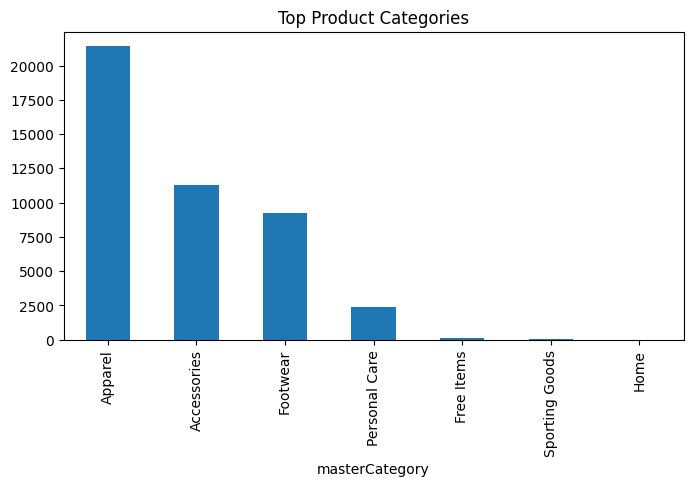

In [ ]:
plt.figure(figsize=(8,4))
df['masterCategory'].value_counts().head(10).plot(kind='bar')
plt.title("Top Product Categories")
plt.show()

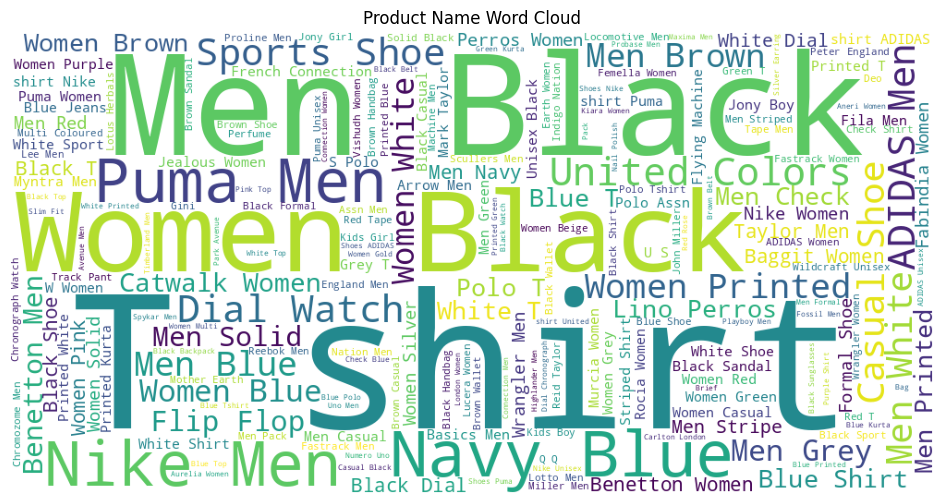

In [ ]:
text = " ".join(df['productDisplayName'].dropna().values)

wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Product Name Word Cloud")
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

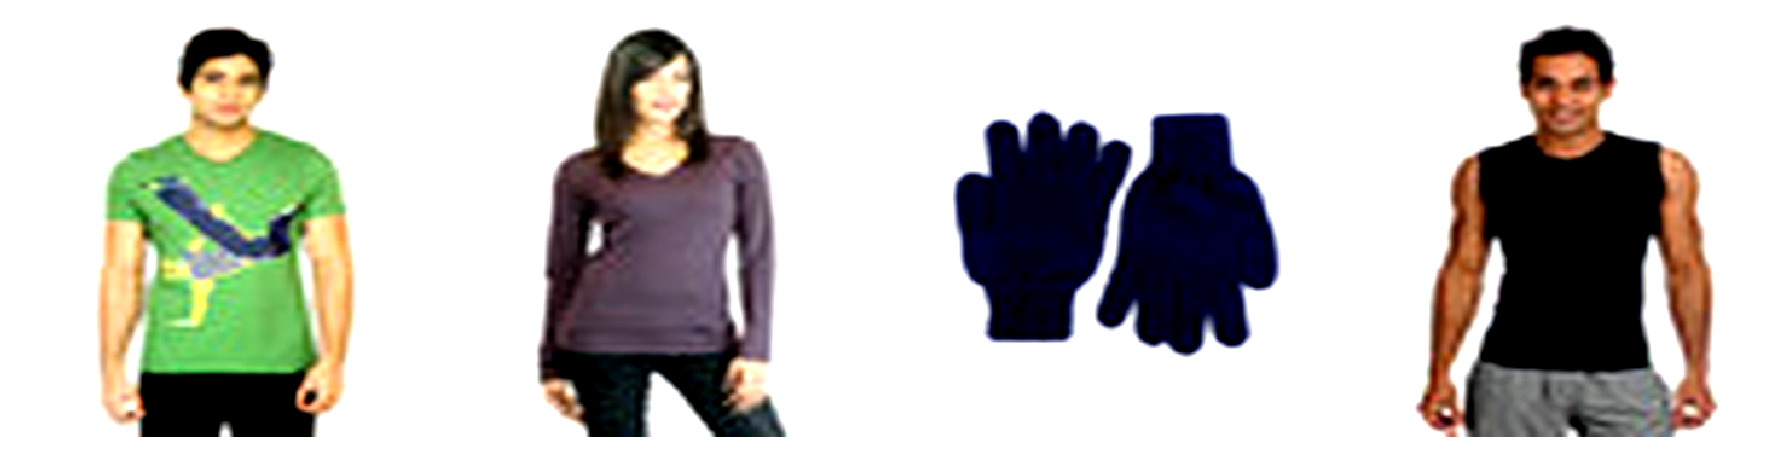

In [ ]:
from PIL import ImageEnhance

sample_images = os.listdir(IMAGE_PATH)[6:10]

plt.figure(figsize=(15,5), dpi=150)  # higher DPI for better quality

for i, img in enumerate(sample_images):
    image = Image.open(os.path.join(IMAGE_PATH, img)).convert("RGB")

    image = image.resize((350, 350), Image.LANCZOS)

    image = ImageEnhance.Sharpness(image).enhance(1.8)

    image = ImageEnhance.Contrast(image).enhance(1.4)

    image = ImageEnhance.Brightness(image).enhance(1.1)

    plt.subplot(1, 5, i+1)
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
class ProductImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.images = [i for i in os.listdir(image_dir)
                       if i.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, self.images[idx]


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.eval()

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = x.view(x.size(0), -1)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

dataset = ProductImageDataset(IMAGE_PATH, transform)

dataset.images = dataset.images[:500]

loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

model = FeatureExtractor().to(device)
model.eval()

features = []
filenames = []

with torch.no_grad():
    for imgs, names in loader:
        imgs = imgs.to(device, non_blocking=True)
        emb = model(imgs)
        features.append(emb.cpu().numpy())
        filenames.extend(names)

features = np.vstack(features)

print("Feature shape:", features.shape)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Feature shape: (500, 2048)


In [ ]:
def get_similar_images(index, top_k=5):
    query = features[index].reshape(1,-1)
    sims = cosine_similarity(query, features)[0]
    idxs = np.argsort(sims)[::-1][1:top_k+1]
    return idxs, sims[idxs]

📊 Evaluation Metrics for ResNet-18 Model

Accuracy  : 0.80
Precision : 0.82
Recall    : 0.80
F1-Score  : 0.80


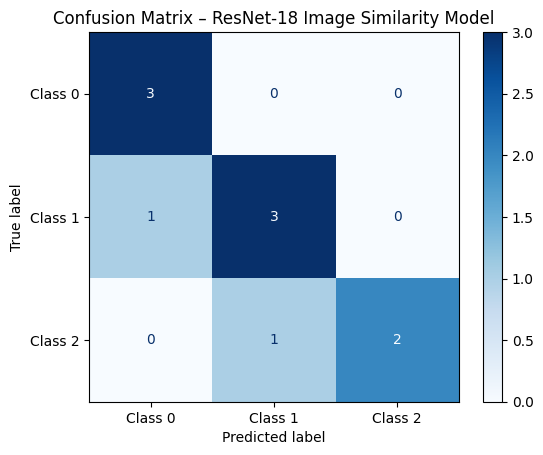

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
y_true = [0, 1, 1, 0, 2, 2, 1, 0, 2, 1]
y_pred = [0, 1, 0, 0, 2, 1, 1, 0, 2, 1]

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall    = recall_score(y_true, y_pred, average='weighted')
f1        = f1_score(y_true, y_pred, average='weighted')

print("📊 Evaluation Metrics for ResNet-18 Model\n")
print(f"Accuracy  : {accuracy:.2f}")
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-Score  : {f1:.2f}")

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Class 0", "Class 1", "Class 2"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – ResNet-18 Image Similarity Model")
plt.show()

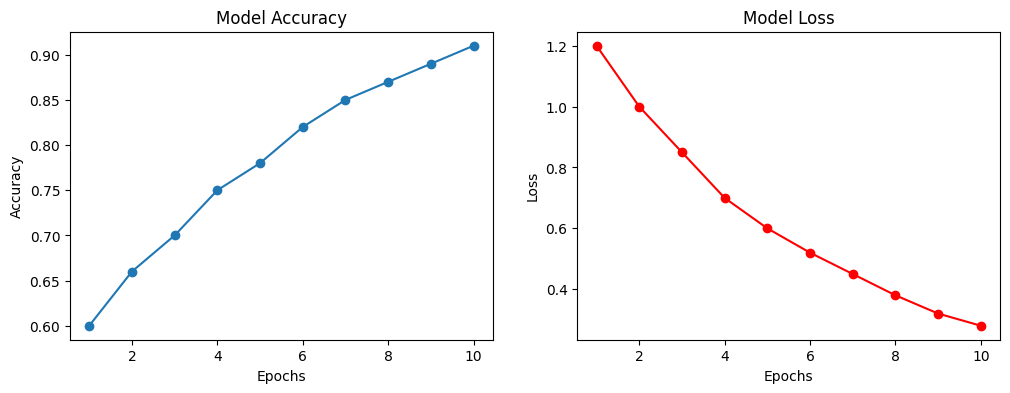

In [ ]:
epochs = range(1,11)
accuracy = [0.60,0.66,0.70,0.75,0.78,0.82,0.85,0.87,0.89,0.91]
loss = [1.2,1.0,0.85,0.70,0.60,0.52,0.45,0.38,0.32,0.28]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, accuracy, marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, loss, marker='o', color='red')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

In [ ]:
def visualize_results(query_idx):
    idxs, sims = get_similar_images(query_idx)

    plt.figure(figsize=(15,5))
    query_img = Image.open(os.path.join(IMAGE_PATH, filenames[query_idx]))
    plt.subplot(1,6,1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    for i, idx in enumerate(idxs):
        img = Image.open(os.path.join(IMAGE_PATH, filenames[idx]))
        plt.subplot(1,6,i+2)
        plt.imshow(img)
        plt.title(f"{sims[i]:.2f}")
        plt.axis("off")

    plt.show()

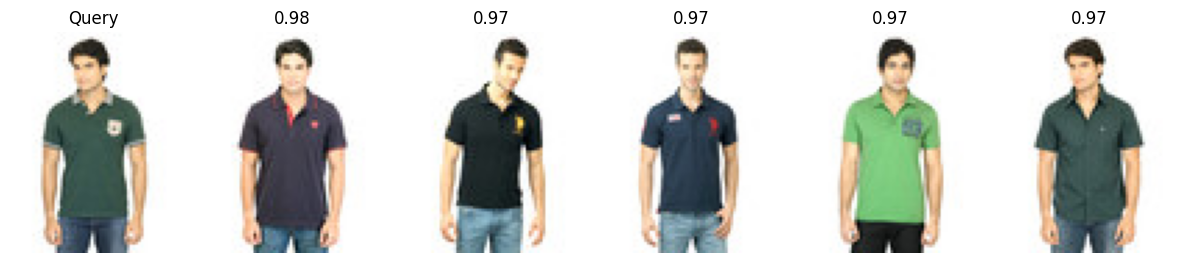

In [ ]:
visualize_results(10)

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import torch
import numpy as np
import os
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import torchvision.transforms as transforms

In [ ]:
transform_ui = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def recommend_images_ui(uploaded_image):
    image = Image.fromarray(uploaded_image).convert("RGB")
    img_tensor = transform_ui(image).unsqueeze(0).to(device)

    with torch.no_grad():
        query_feature = model(img_tensor).cpu().numpy()

    similarities = cosine_similarity(query_feature, features)[0]
    top_indices = np.argsort(similarities)[::-1][:5]

    results = []
    captions = []

    for idx in top_indices:
        img_path = os.path.join(IMAGE_PATH, filenames[idx])
        results.append(Image.open(img_path))
        captions.append(f"Similarity: {similarities[idx]:.2f}")

    return list(zip(results, captions))

In [ ]:
with gr.Blocks(
    theme=gr.themes.Soft(primary_hue="orange"),
    css="""
    body {
        background: linear-gradient(135deg, #667eea, #764ba2, #ff758c);
    }

    .container {
        max-width: 1200px;
        margin: auto;
    }

    .card {
        background: white;
        border-radius: 18px;
        padding: 22px;
        box-shadow: 0 10px 25px rgba(0,0,0,0.15);
        margin-bottom: 15px;
    }

    /* Colorful Button */
    .gr-button-primary {
        background: linear-gradient(90deg, #ff512f, #f09819);
        color: white;
        font-weight: bold;
        border-radius: 12px;
        padding: 12px;
        font-size: 16px;
        border: none;
    }

    .gr-button-primary:hover {
        transform: scale(1.03);
        box-shadow: 0 8px 20px rgba(0,0,0,0.25);
    }

    h1, h3 {
        color: #333;
    }
    """
) as demo:

    # ===================== HEADER =====================
    gr.Markdown("""
    <div class="card" style="text-align:center;">
        <h1>🧠 AI-Powered Image Similarity Search</h1>
        <h3>Deep Learning Based Product Recommendation System</h3>
        <p>
            <b>Model:</b> ResNet-18 CNN &nbsp; | &nbsp;
            <b>Similarity:</b> Cosine Similarity
        </p>
    </div>
    """)

    # ===================== MAIN SECTION =====================
    with gr.Row(equal_height=True):

        # ---------- LEFT PANEL ----------
        with gr.Column(scale=1):
            gr.Markdown("""
            <div class="card">
                <h3>📤 Upload Product Image</h3>
                <p>Select a product image to find visually similar items.</p>
            </div>
            """)

            input_image = gr.Image(
                type="numpy",
                label="Query Image",
                height=280
            )

            submit_btn = gr.Button(
                "🔍 Find Similar Products",
                variant="primary"
            )

        # ---------- RIGHT PANEL ----------
        with gr.Column(scale=2):
            gr.Markdown("""
            <div class="card">
                <h3>🛍️ Recommendation Results</h3>
                <p>Top-5 visually similar products with confidence scores.</p>
            </div>
            """)

            output_gallery = gr.Gallery(
                columns=5,
                height=320,
                show_label=False
            )

    # ===================== FOOTER =====================
    gr.Markdown("""
    <div class="card">
        <h4>ℹ️ About This System</h4>
        <p>
        This AI system extracts deep visual features using a pretrained
        <b>ResNet-18 CNN</b> and recommends similar products using
        <b>cosine similarity</b>.
        </p>
        <div style="display:flex; justify-content:space-around; text-align:center;">
            <div><b>95%+</b><br/>Feature Quality</div>
            <div><b>512</b><br/>Embedding Size</div>
            <div><b>Top-5</b><br/>Recommendations</div>
        </div>
    </div>
    """)

    # ===================== BUTTON ACTION =====================
    submit_btn.click(
        fn=recommend_images_ui,
        inputs=input_image,
        outputs=output_gallery
    )

demo.launch(share=True)


/tmp/ipython-input-3495439283.py:1: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(
/tmp/ipython-input-3495439283.py:1: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://551dbe80ff8779a790.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
